1687021949.370511
1687021949.3709388
1687021949.371443


/var/folders/vf/842hmrqn18z65j0fs1m3p8200000gn/T/ipykernel_7611/802835142.py:27: RuntimeWarning: overflow encountered in exp
  return 1 / (np.exp(beta*E) + 1 )


1687023876.445708


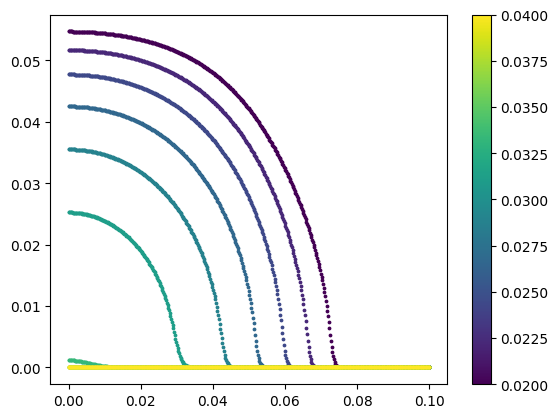

ValueError: 'viridis' is not a valid value for color

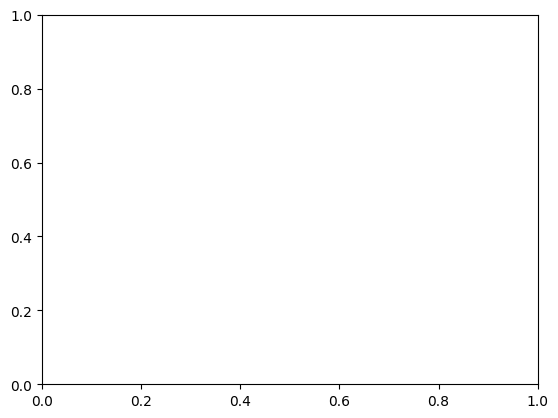

In [ ]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from time import time
#from scipy.integrate import quad

print(time())

## gap_eq をdef

def e_k_spin(k1, k2, q, y, B): 
    return 2*t*(np.cos(a*(k1+q/2))+np.cos(a*(k2))) - u + y * 1/2 * gu * B

def e_k_s(k1, k2, q, B):
    return (e_k_spin(k1, k2, q, 1, B) + e_k_spin(-1*k1, k2, q, -1, B))/2

def e_k_a(k1, k2, q, B):
    return (e_k_spin(k1, k2, q, 1, B) - e_k_spin(-1*k1, k2, q, -1, B))/2

def E_k_q(k1, k2, gap, q, B):
    return np.sqrt(e_k_s(k1, k2, q, B)**2 + gap**2)

def E_k_q_s(k1, k2, gap, q, y, B):
    return E_k_q(k1, k2, gap, q, B) + y * e_k_a(k1, k2, q, B)

def Fermi(beta, E):
    return 1 / (np.exp(beta*E) + 1 )

def func(k1, k2, gap, q, B): 
    return gap*(1-Fermi(beta, E_k_q_s(k1, k2, gap, q, -1, B))-Fermi(beta, E_k_q_s(k1, k2, gap, q, 1, B)))/(2*E_k_q(k1, k2, gap, q, B))

def rhs(gap, q, B):
    k1 = -1 * np.pi/a + 2 * arange(N) * np.pi / (a * N)
    kx, ky = meshgrid(k1, k1, indexing='ij')
    f = func(kx, ky, gap, q, B)
    return (V / (N**2)) * sum(f)

print(time())

##パラメータの調整
N, V, t, a, u, gu, n0, n1, n2 =100, 1, 1, 1, 0, 1, 500, 1, 10    # 7.525 #9.21
qs   = np.linspace(0,0.1,n0)  #(np.pi/a)
Bs   = np.linspace(0.0,0.1,n1)     #np.linspace(0,0.08,n1)
kBTs = np.linspace(0.02,0.04,n2)

print(time())

##ギャップの逐次計算
ans = []
for h in range(n0):
    ans0 = []
    for i in range(n1):
        ans1 = []
        for j in range(n2): # それぞれの温度で秩序パラメータを計算
            beta, d0 = 1/kBTs[j], 100.0
            for k in range(1000): # 収束するまで最大1000回ループ
                d1 = rhs(d0, qs[h], Bs[i]) 
                if abs(d1-d0) < 1e-10: break # 収束チェック
                d0 = d1
            ans1.append([d0, abs(d1-d0), k])
        ans0.append(ans1)
    ans.append(ans0)
ans = np.array(ans)

print(time())


##gapのq依存
for j in range(n2):    ##q,gap図
    for i in range(n1):
        ans_q = []
        for h in range(n0):
            ans_q.append(ans[h][i][j][0])
            figure = plt.scatter(qs[h], ans[h][i][j][0], 3, c=kBTs[j],  cmap='viridis' ,vmin=0.02, vmax=0.04)
c= plt.colorbar()
plt.savefig("FFLO_q-gap(N=100,B=0.00).png")
plt.show()



##gapの温度依存
for h in range(n0):    ##kBT,gap
    for i in range(n1):
        plt.plot(kBTs, ans[h][i][:,0], label = 'B='+str(Bs[i])+', q='+str(qs[h])) # 秩序パラメータの温度依存性をプロット
plt.legend()
plt.show()


##反復回数の温度依存
for h in range(n0):    ##kBT,反復回数　図
    for i in range(n1):
        plt.plot(kBTs, ans[h][i][:,2],label = 'B='+str(Bs[i])+', q='+str(qs[h]) , color=(h/n0,i/n1,1-i/n1,1-(h/n0)/2)) # 収束に必要だった反復回数のプロット
plt.legend()
plt.show()

print(time())

def rhs(gap, q, B):
    k1 = -1 * np.pi/a + 2 * arange(N) * np.pi / (a * N)
    kx, ky = meshgrid(k1, k1, indexing='ij')
    f = func(kx, ky, gap, q, B)
    return (V / (N**2)) * sum(f)


#free energy の定義

def F1(h):
    sum = 0
    for n1 in range(N):
        k1 = -1 * np.pi/a + 2 * n1 * np.pi / (a * N)
        for n2 in range(N):
            k2 = -1 * np.pi/a + 2 * n2 * np.pi / (a * N)
            for y in range(-1,1):
                sum = sum + np.log(1+np.exp(-1*beta*E_k_q_s(k1, k2, ans_q[h], qs[h], y, B)))
    return -1*1/beta*sum

def F0(h):
    sum = 0
    for n1 in range(N):
        k1 = -1 * np.pi/a + 2 * n1 * np.pi / (a * N)
        for n2 in range(N):
            k2 = -1 * np.pi/a + 2 * n2 * np.pi / (a * N)
            sum = sum + e_k_spin(-1*k1, -1*k2, qs[h], -1, B) - E_k_q_s(k1, k2, ans_q[h], qs[h], -1, B)
    return sum

def Fc(h):
    return(N**2)*(ans_q[h]**2)/V

def free_energy(h):              #vn0 = (v / n^2) * n0
    return F1(h) + F0(h) + Fc(h)

for h in range(n0):
    print(ans_q[h])

#free energy の計算
kBT = kBTs[0]
beta = 1/kBT
B = Bs[0]
ans_F0 = []
for h in range(n0):
    ans = F0(h)
    ans_F0.append(ans)
ans0 = np.array(ans_F0)

ans_F1 = []
for h in range(n0):
    ans = F1(h)
    ans_F1.append(ans)
ans1 = np.array(ans_F1)

ans_FC = []
for h in range(n0):
    ans = Fc(h)
    ans_FC.append(ans)
ansC = np.array(ans_FC)

ans_F = []
for h in range(n0):
    ans = free_energy(h)
    ans_F.append(ans)
ans = np.array(ans_F)

#free energy の描画

plt.scatter(qs, ans1, color=(h/n0,i/n1,1-i/n1,1-(h/n0)/2))
plt.show()

plt.scatter(qs, ans0, color=(h/n0,i/n1,1-i/n1,1-(h/n0)/2))
plt.show()

plt.scatter(qs, ansC, color=(h/n0,i/n1,1-i/n1,1-(h/n0)/2))
plt.show()

plt.scatter(qs, ans, color=(h/n0,i/n1,1-i/n1,1-(h/n0)/2))
plt.show()